In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
from torch.nn.functional import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Load CIFAR10
loading dataset and split the train to train and validation datsets. We also filter them to have just 2 classes.

In [3]:
batch_size = 32
num_classes = 2  # airplane and automobile
learning_rate = 0.001
num_epochs = 10
validation_split = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

class_map = {0: 0, 1: 1}  # airplane -> 0, automobile -> 1

def filter_classes(dataset):
    indices = [i for i, t in enumerate(dataset.targets) if t in class_map]
    dataset.data = dataset.data[indices]
    dataset.targets = [class_map[t] for t in dataset.targets if t in class_map]

filter_classes(full_train_dataset)
filter_classes(test_dataset)

num_train = len(full_train_dataset)
indices = list(range(num_train))
split = int(validation_split * num_train)

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train_and_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, best_model_path):
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    return train_losses, val_losses, train_accuracies, val_accuracies


In [36]:
def plot_training_validation_metrics(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies):

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def plot_training_validation_losses(num_epochs, train_losses, val_losses):

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [34]:
def get_sample_images(dataset, class_map):
    samples = {}
    for i, (image, label) in enumerate(dataset):
        if label not in samples:  # Check if we've already collected a sample for this class
            samples[label] = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)
        if len(samples) == len(class_map):  # If we have all classes, stop searching
            break
    return samples

def visualize_feature_maps(model, layer_names, input_image, device='cuda'):
    model = model.to(device)
    input_image = input_image.to(device)

    # Visualize the input image
    plt.figure(figsize=(1, 1))
    img = input_image[0].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize (from [-1, 1] to [0, 1])
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Hook for capturing the feature maps
    feature_maps = {}

    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output
        return hook

    # Register hooks for the specified layers
    hooks = []
    for name, layer in model.named_modules():
        if name in layer_names:
            hooks.append(layer.register_forward_hook(hook_fn(name)))

    # Forward pass to extract feature maps
    model.eval()
    with torch.no_grad():
        model(input_image)

    # Remove hooks after extraction
    for hook in hooks:
        hook.remove()

    # 2x2 outer grid for 4 layers
    fig = plt.figure(figsize=(16, 12))
    outer = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)

    for i, name in enumerate(layer_names):
        if name in feature_maps:
            fmap = feature_maps[name][0]  # Get feature map for the layer
            num_features = fmap.shape[0]  # Number of feature maps (channels)
            grid_size = int(num_features**0.5) + 1  # Grid size for feature maps

            # Create inner grid for this layer
            inner = gridspec.GridSpecFromSubplotSpec(grid_size, grid_size,
                                                     subplot_spec=outer[i], wspace=0.1, hspace=0.1)
            for j in range(num_features):
                row, col = divmod(j, grid_size)
                ax = fig.add_subplot(inner[row, col])
                feature_map = fmap[j].cpu().numpy()  # Extract the j-th feature map
                ax.imshow(feature_map, cmap='viridis')
                ax.axis('off')

            # Add a title for the layer
            ax = fig.add_subplot(outer[i])
            ax.set_title(f"{name}", fontsize=14, pad=20)
            ax.axis('off')

    plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Update the output layer for 2 classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="Best_CE_Model.pth"
)

Epoch [1/10], Train Loss: 0.2490, Val Loss: 0.0856, Train Acc: 0.9080, Val Acc: 0.9700
Epoch [2/10], Train Loss: 0.1084, Val Loss: 0.1051, Train Acc: 0.9615, Val Acc: 0.9555
Epoch [3/10], Train Loss: 0.0813, Val Loss: 0.0658, Train Acc: 0.9708, Val Acc: 0.9770
Epoch [4/10], Train Loss: 0.0528, Val Loss: 0.1164, Train Acc: 0.9828, Val Acc: 0.9565
Epoch [5/10], Train Loss: 0.0542, Val Loss: 0.0708, Train Acc: 0.9788, Val Acc: 0.9710
Epoch [6/10], Train Loss: 0.0409, Val Loss: 0.0835, Train Acc: 0.9846, Val Acc: 0.9725
Epoch [7/10], Train Loss: 0.0436, Val Loss: 0.0873, Train Acc: 0.9849, Val Acc: 0.9700
Epoch [8/10], Train Loss: 0.0285, Val Loss: 0.1099, Train Acc: 0.9898, Val Acc: 0.9700
Epoch [9/10], Train Loss: 0.0263, Val Loss: 0.0809, Train Acc: 0.9901, Val Acc: 0.9690
Epoch [10/10], Train Loss: 0.0250, Val Loss: 0.0722, Train Acc: 0.9920, Val Acc: 0.9710


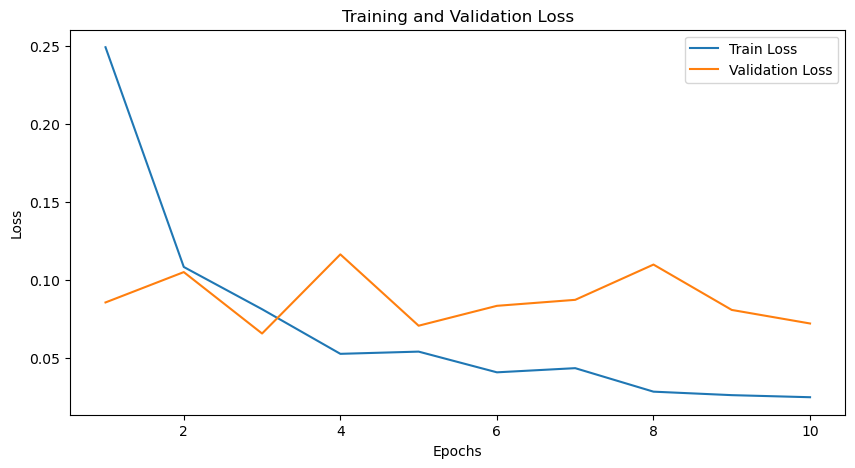

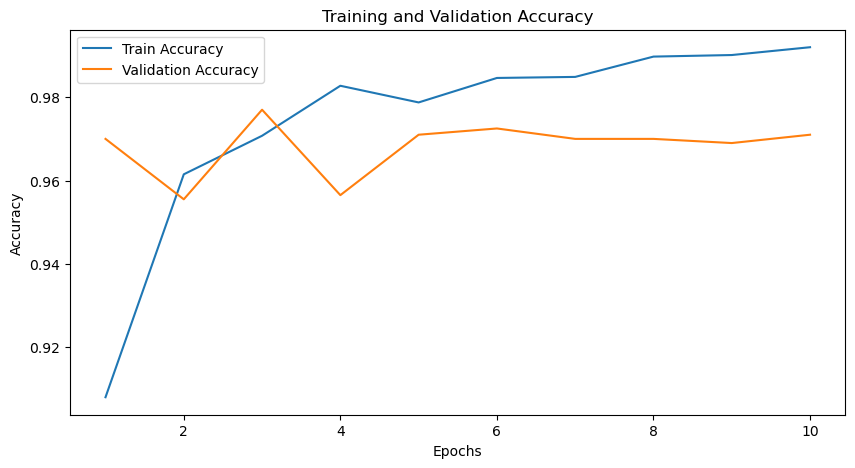

In [10]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

Visualizing feature maps for class: Automobile


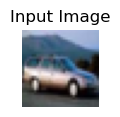

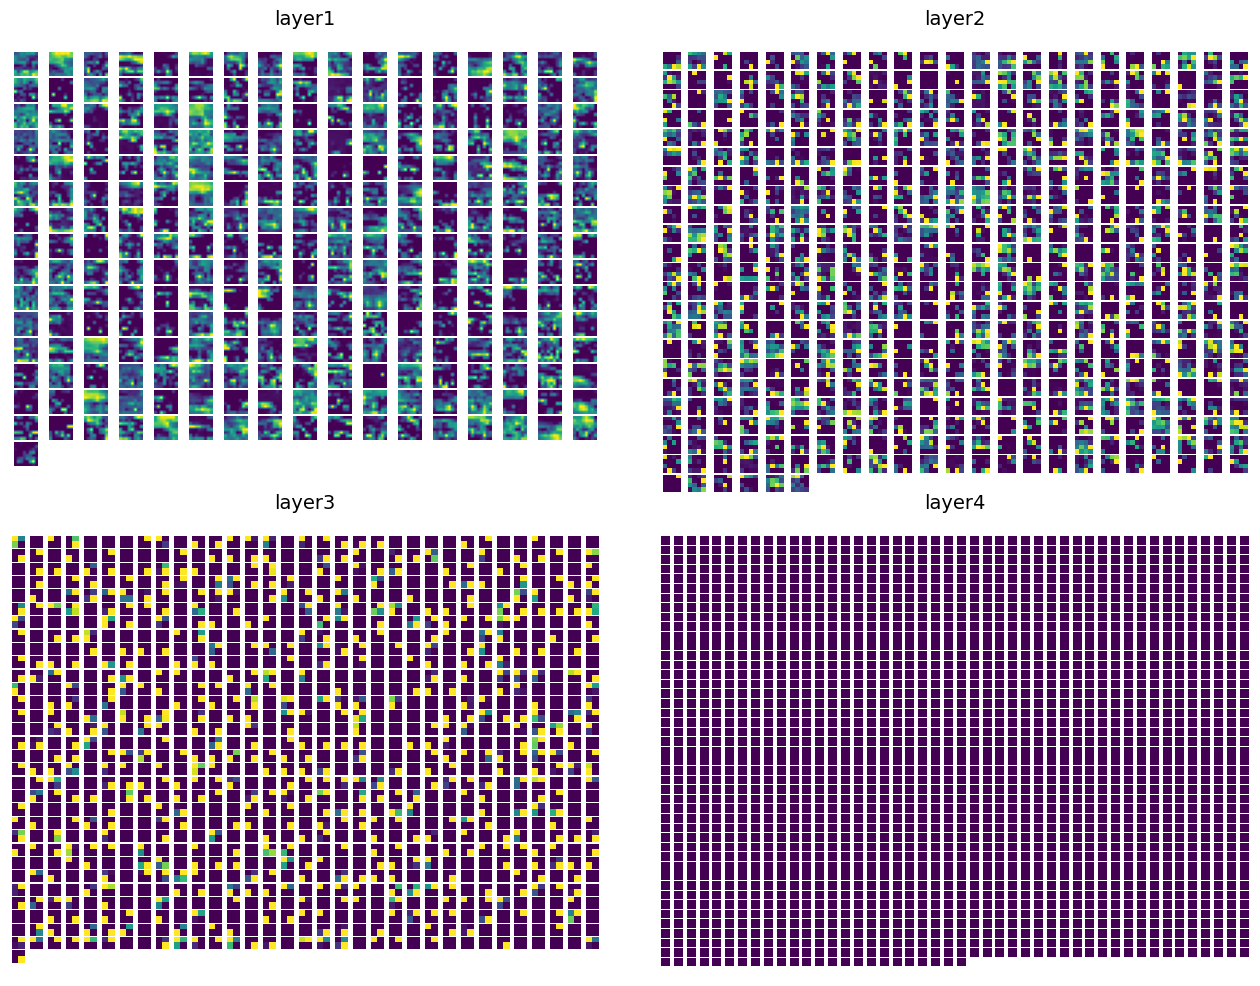

Visualizing feature maps for class: Airplane


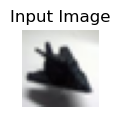

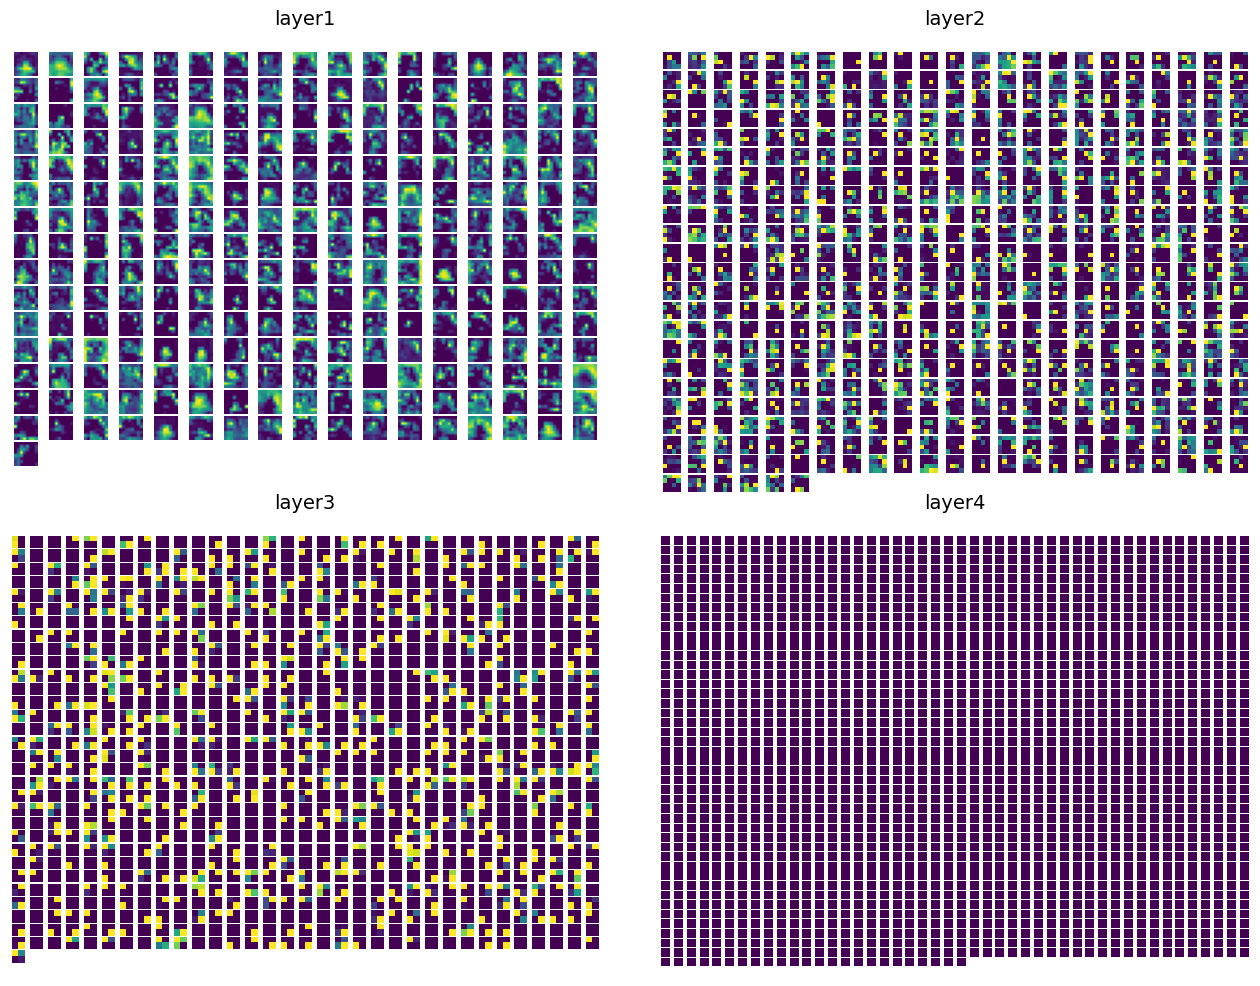

In [22]:
# Extract one image per class from the filtered dataset
sample_images = get_sample_images(full_train_dataset, class_map)

# Specify the layers you want to visualize
layers_to_visualize = ['layer1', 'layer2', 'layer3', 'layer4']  # Replace with actual layer names

# Visualize feature maps for each class
for label, image in sample_images.items():
    class_name = 'Airplane' if label == 0 else 'Automobile'
    print(f"Visualizing feature maps for class: {class_name}")
    visualize_feature_maps(model, layers_to_visualize, image)

## Triplet Loss

In [22]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        # Find a positive sample (same class)
        positive_index = index
        while positive_index == index or self.dataset[positive_index][1] != anchor_label:
            positive_index = torch.randint(0, len(self.dataset), (1,)).item()
        positive_img, _ = self.dataset[positive_index]

        # Find a negative sample (different class)
        negative_index = index
        while negative_index == index or self.dataset[negative_index][1] == anchor_label:
            negative_index = torch.randint(0, len(self.dataset), (1,)).item()
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)


In [23]:
def train_and_validate_triplet_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, best_model_path):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Forward pass
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            # Compute loss
            loss = criterion(anchor_out, positive_out, negative_out)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                # Forward pass
                anchor_out = model(anchor)
                positive_out = model(positive)
                negative_out = model(negative)

                # Compute loss
                loss = criterion(anchor_out, positive_out, negative_out)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    return train_losses, val_losses

In [27]:
class ResNetEmbedding(nn.Module):
    def __init__(self, base_model, embedding_dim=128):
        super(ResNetEmbedding, self).__init__()
        self.base = nn.Sequential(*list(base_model.children())[:-1])
        self.embedding_layer = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout with 50% probability
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        x = self.base(x)
        x = torch.flatten(x, 1)
        x = self.embedding_layer(x)
        x = normalize(x, p=2, dim=1)
        return x

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter classes (airplane and automobile)
class_map = {0: 0, 1: 1}  # airplane -> 0, automobile -> 1

def filter_classes(dataset):
    indices = [i for i, t in enumerate(dataset.targets) if t in class_map]
    dataset.data = dataset.data[indices]
    dataset.targets = [class_map[t] for t in dataset.targets if t in class_map]

filter_classes(train_dataset)
filter_classes(test_dataset)

# Split the training dataset into train and validation subsets
validation_split = 0.2
num_train = len(train_dataset)
num_val = int(validation_split * num_train)
num_train = num_train - num_val

train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Wrap the subsets into Triplet Datasets
train_triplet_dataset = TripletDataset(train_subset)
val_triplet_dataset = TripletDataset(val_subset)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_triplet_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
embedding_dim = 128
base_model = models.resnet50(pretrained=True)
model = ResNetEmbedding(base_model, embedding_dim)
model = model.to(device)

# Define Triplet Loss and optimizer
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_epochs = 10

In [45]:
# Train feature extractor with Triplet Loss
train_losses, val_losses = train_and_validate_triplet_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="Best_Triplet_Model.pth"
)

Epoch [1/10], Train Loss: 0.3276, Val Loss: 0.2358
Epoch [2/10], Train Loss: 0.1749, Val Loss: 0.2237
Epoch [3/10], Train Loss: 0.1124, Val Loss: 0.2269
Epoch [4/10], Train Loss: 0.1261, Val Loss: 0.2202
Epoch [5/10], Train Loss: 0.1065, Val Loss: 0.1653
Epoch [6/10], Train Loss: 0.0745, Val Loss: 0.1327
Epoch [7/10], Train Loss: 0.0705, Val Loss: 0.1292
Epoch [8/10], Train Loss: 0.0896, Val Loss: 0.2425
Epoch [9/10], Train Loss: 0.0980, Val Loss: 0.1488
Epoch [10/10], Train Loss: 0.0806, Val Loss: 0.1573


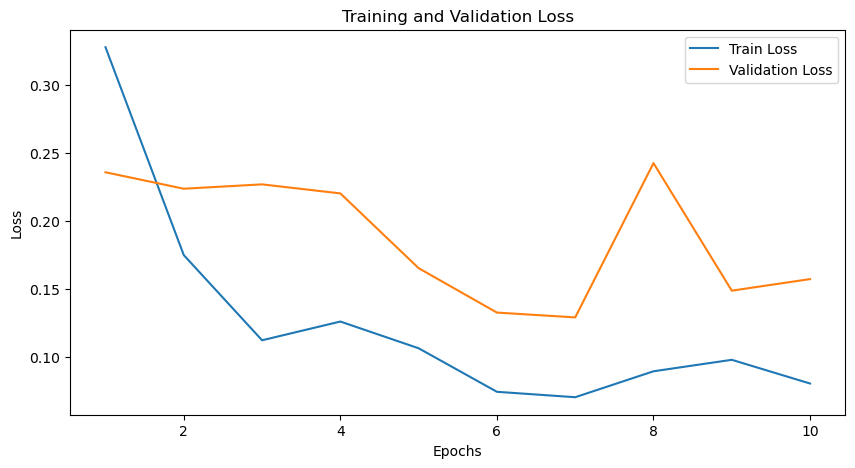

In [46]:
plot_training_validation_losses(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
)

In [49]:
# Freeze feature extractor parameters
for param in model.base.parameters():
    param.requires_grad = False

# Add and train a fully connected layer with Cross-Entropy Loss
fc_layer = nn.Sequential(
    nn.Linear(embedding_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 2)  # Output layer for 2 classes (airplane and automobile)
)
fc_layer = fc_layer.to(device)

# Define Cross-Entropy Loss and optimizer for the fully connected layer
ce_criterion = nn.CrossEntropyLoss()
ce_optimizer = optim.Adam(fc_layer.parameters(), lr=learning_rate)

# Update DataLoader to use labeled data for classification
classification_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
classification_val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

def train_and_validate_classification_model(feature_extractor, fc_layer, train_loader, val_loader, optimizer, criterion, num_epochs, device, best_model_path):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        feature_extractor.eval()  # Keep feature extractor frozen
        fc_layer.train()

        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                features = feature_extractor(images)
            outputs = fc_layer(features)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation phase
        fc_layer.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                features = feature_extractor(images)
                outputs = fc_layer(features)

                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val

        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")
        
        # Save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), best_model_path)

    return train_losses, val_losses, train_accuracies, val_accuracies


In [50]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_classification_model(
    feature_extractor=model,
    fc_layer=fc_layer,
    train_loader=classification_train_loader,
    val_loader=classification_val_loader,
    optimizer=ce_optimizer,
    criterion=ce_criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path = "Best_Triplet_with_FC_Model.pth"
)

Epoch [1/10] - Train Loss: 0.0886, Train Accuracy: 0.9839, Val Loss: 0.1560, Val Accuracy: 0.9580
Epoch [2/10] - Train Loss: 0.0537, Train Accuracy: 0.9848, Val Loss: 0.1222, Val Accuracy: 0.9605
Epoch [3/10] - Train Loss: 0.0490, Train Accuracy: 0.9842, Val Loss: 0.1306, Val Accuracy: 0.9600
Epoch [4/10] - Train Loss: 0.0486, Train Accuracy: 0.9848, Val Loss: 0.1289, Val Accuracy: 0.9610
Epoch [5/10] - Train Loss: 0.0474, Train Accuracy: 0.9849, Val Loss: 0.1229, Val Accuracy: 0.9600
Epoch [6/10] - Train Loss: 0.0466, Train Accuracy: 0.9846, Val Loss: 0.1306, Val Accuracy: 0.9605
Epoch [7/10] - Train Loss: 0.0469, Train Accuracy: 0.9851, Val Loss: 0.1154, Val Accuracy: 0.9595
Epoch [8/10] - Train Loss: 0.0467, Train Accuracy: 0.9852, Val Loss: 0.1254, Val Accuracy: 0.9605
Epoch [9/10] - Train Loss: 0.0460, Train Accuracy: 0.9852, Val Loss: 0.1325, Val Accuracy: 0.9605
Epoch [10/10] - Train Loss: 0.0465, Train Accuracy: 0.9849, Val Loss: 0.1228, Val Accuracy: 0.9580


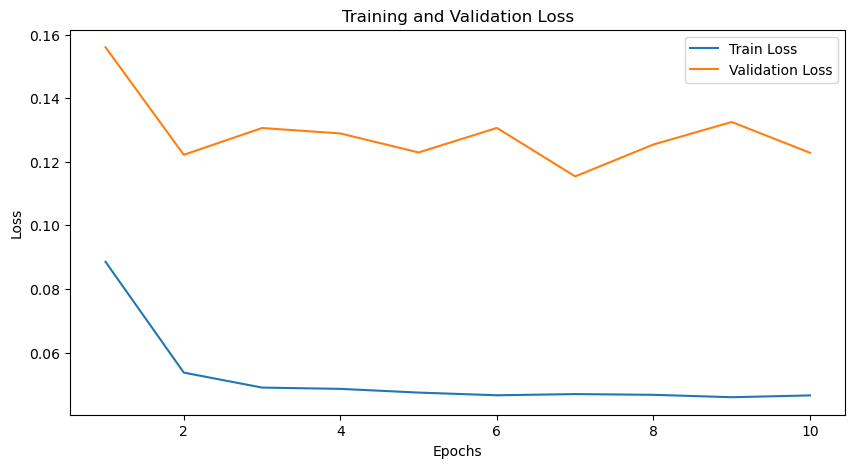

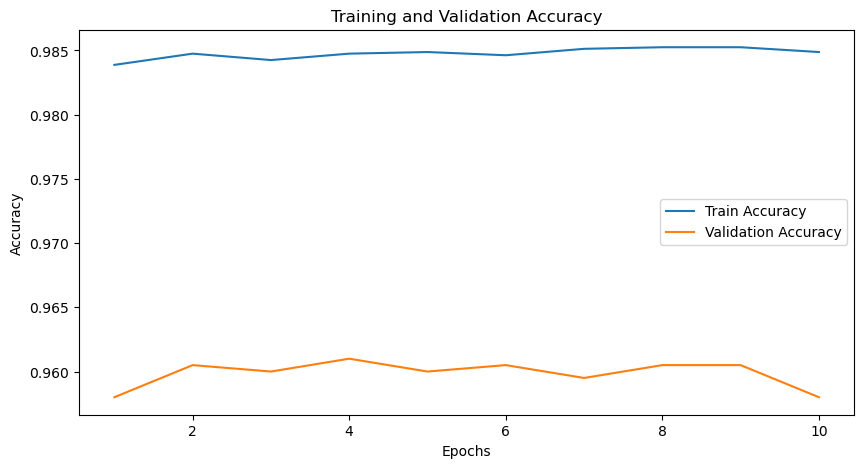

In [51]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

### Test

In [53]:
def evaluate_on_test(feature_extractor, fc_layer, test_loader, device):
    feature_extractor.eval()
    fc_layer.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            outputs = fc_layer(features)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = correct / total
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, cm

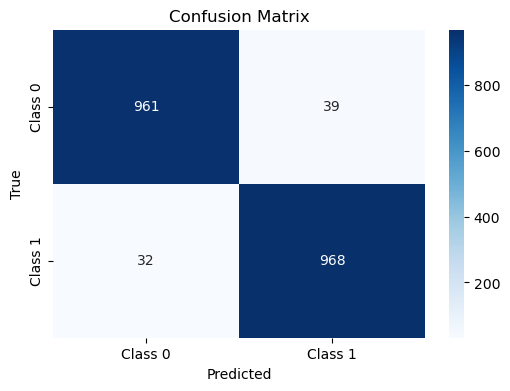

Test Accuracy: 0.9645


In [54]:
accuracy, cm = evaluate_on_test(model, fc_layer, test_loader, device)

Visualizing feature maps for class: Automobile


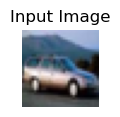

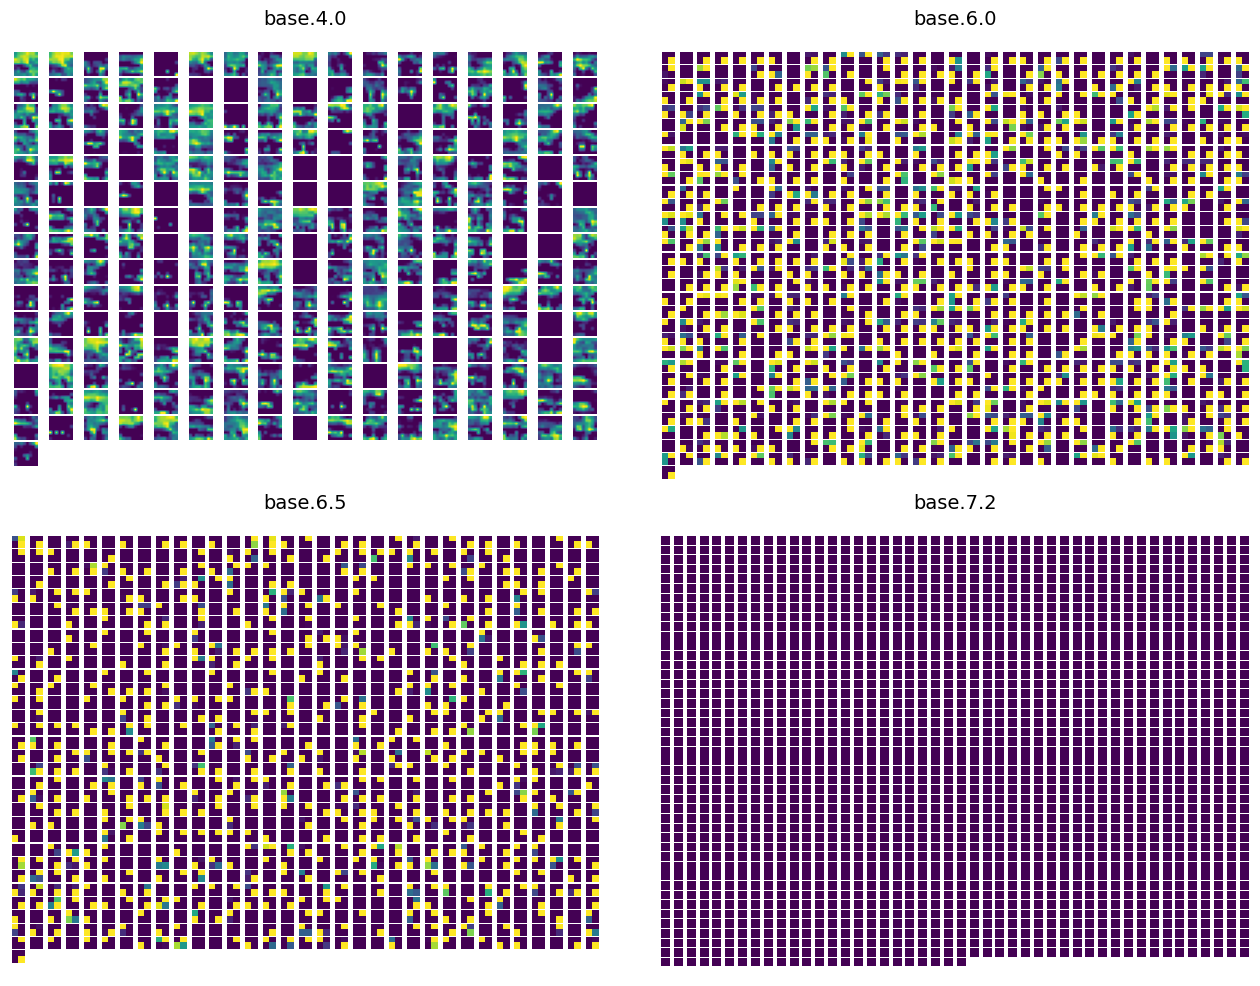

Visualizing feature maps for class: Airplane


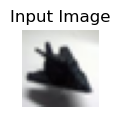

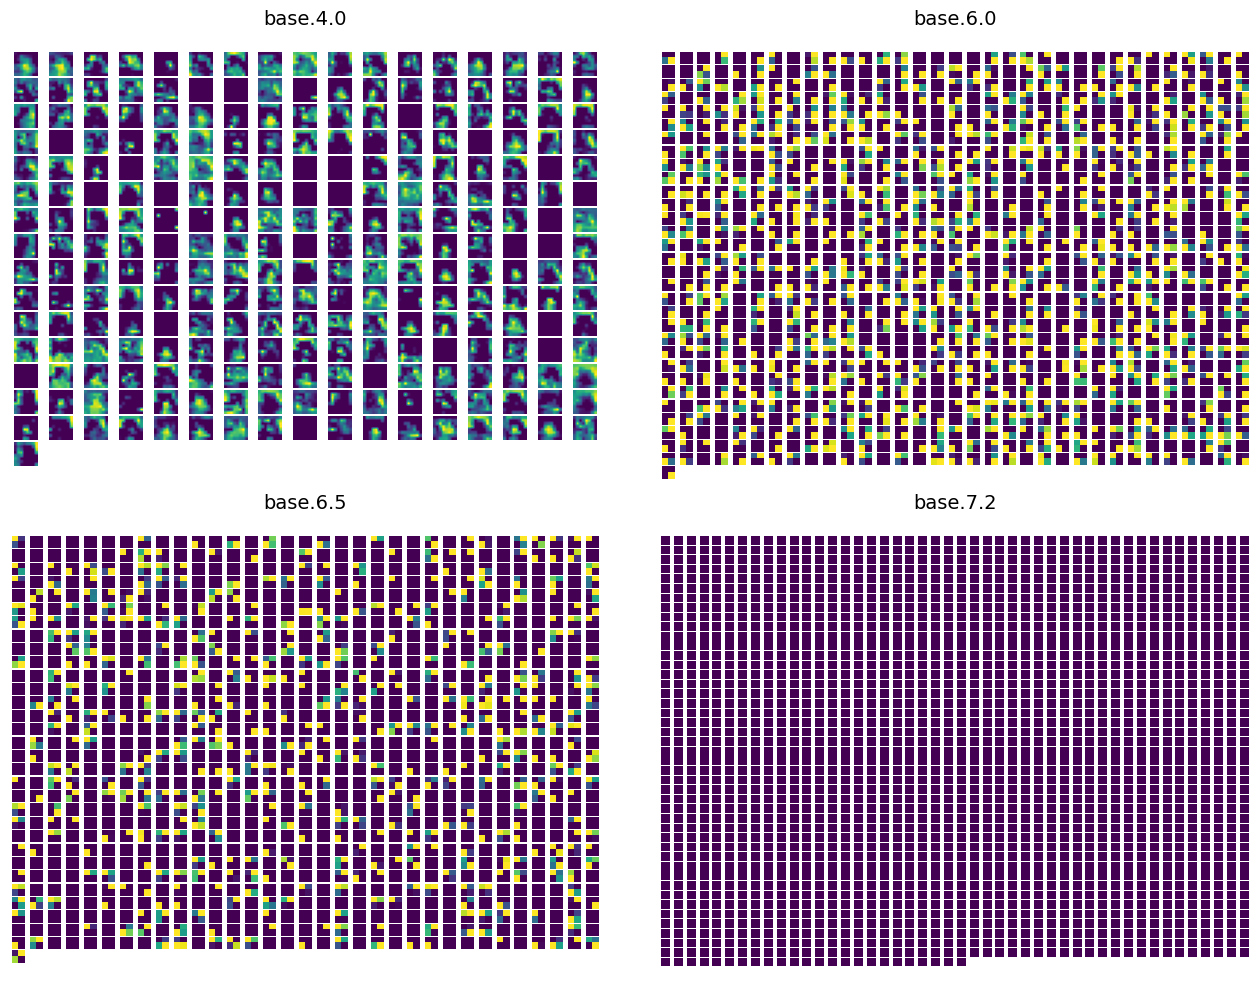

In [64]:
# Extract one image per class from the filtered dataset
sample_images = get_sample_images(full_train_dataset, class_map)

layers_to_visualize = ['base.4.0', 'base.6.0', 'base.6.5', 'base.7.2']

# Visualize feature maps for each class using the feature extractor
for label, image in sample_images.items():
    class_name = 'Airplane' if label == 0 else 'Automobile'
    print(f"Visualizing feature maps for class: {class_name}")
    visualize_feature_maps(model, layers_to_visualize, image)

## Some of Both Losses

In [81]:
class TripletDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset  # Save the passed dataset
        if isinstance(base_dataset, Subset):  # Handle Subset objects
            self.indices = base_dataset.indices
            self.data = base_dataset.dataset.data[self.indices]
            self.labels = np.array(base_dataset.dataset.targets)[self.indices]
            self.transform = base_dataset.dataset.transform
        else:  # Handle full dataset objects
            self.data = base_dataset.data
            self.labels = np.array(base_dataset.targets)
            self.transform = base_dataset.transform

        # Group indices by class
        self.class_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

        for k in self.class_to_indices:
            self.class_to_indices[k] = np.array(self.class_to_indices[k])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        anchor_img = self.data[index]
        anchor_label = self.labels[index]

        if isinstance(anchor_img, np.ndarray):
            anchor_img = Image.fromarray(anchor_img)

        # Get positive sample
        pos_indices = self.class_to_indices[anchor_label]
        pos_index = np.random.choice(pos_indices[pos_indices != index])
        pos_img = self.data[pos_index]
        if isinstance(pos_img, np.ndarray):
            pos_img = Image.fromarray(pos_img)

        # Get negative sample
        neg_label = np.random.choice([lbl for lbl in self.class_to_indices.keys() if lbl != anchor_label])
        neg_indices = self.class_to_indices[neg_label]
        neg_index = np.random.choice(neg_indices)
        neg_img = self.data[neg_index]
        if isinstance(neg_img, np.ndarray):
            neg_img = Image.fromarray(neg_img)

        # Apply transforms if they exist
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anchor_img, pos_img, neg_img, anchor_label


In [82]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
class_map = {0: 0, 1: 1}  # Filter airplane (0) and automobile (1)
def filter_classes(dataset):
    indices = [i for i, t in enumerate(dataset.targets) if t in class_map]
    dataset.data = dataset.data[indices]
    dataset.targets = [class_map[t] for t in dataset.targets if t in class_map]

filter_classes(full_train_dataset)
validation_split = 0.2
num_train = len(full_train_dataset)
num_val = int(num_train * validation_split)
num_train = num_train - num_val

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [num_train, num_val])

train_triplet_dataset = TripletDataset(train_dataset)
val_triplet_dataset = TripletDataset(val_dataset)

batch_size = 32

train_loader = DataLoader(train_triplet_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [83]:
class FullModel(nn.Module):
    def __init__(self, feature_dim=128, num_classes=2):
        super(FullModel, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.embedding_layer = nn.Linear(2048, feature_dim)  # Embedding layer for triplet loss
        self.classifier = nn.Linear(feature_dim, num_classes)  # Classification layer

    def forward(self, x):
        features = self.feature_extractor(x)  # [B, 2048, 1, 1]
        features = torch.flatten(features, start_dim=1)  # [B, 2048]
        embeddings = self.embedding_layer(features)  # [B, feature_dim]
        logits = self.classifier(embeddings)  # [B, num_classes]
        return embeddings, logits

In [87]:
def train_model_both_losses(model, train_loader, val_loader, optimizer, num_epochs, device, best_model_path):
    triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
    cross_entropy_loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # ------------------------
        # Training Phase
        # ------------------------
        model.train()
        total_train_triplet_loss = 0.0
        total_train_cross_entropy_loss = 0.0
        correct_train = 0
        total_train = 0

        for anchor, positive, negative, labels in train_loader:
            anchor, positive, negative, labels = (
                anchor.to(device),
                positive.to(device),
                negative.to(device),
                labels.to(device).long()  # Ensure labels are of type torch.int64
            )

            # Forward pass
            a_emb, a_logits = model(anchor)
            p_emb, _ = model(positive)
            n_emb, _ = model(negative)

            # Compute losses
            triplet_loss = triplet_loss_fn(a_emb, p_emb, n_emb)
            cross_entropy_loss = cross_entropy_loss_fn(a_logits, labels)
            total_loss = triplet_loss + cross_entropy_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_train_triplet_loss += triplet_loss.item()
            total_train_cross_entropy_loss += cross_entropy_loss.item()

            # Compute training accuracy
            _, predicted = torch.max(a_logits, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_triplet_loss = total_train_triplet_loss / len(train_loader)
        avg_train_cross_entropy_loss = total_train_cross_entropy_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        train_losses.append(avg_train_triplet_loss + avg_train_cross_entropy_loss)
        train_accuracies.append(train_accuracy)

        # ------------------------
        # Validation Phase
        # ------------------------
        model.eval()
        total_val_triplet_loss = 0.0
        total_val_cross_entropy_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for anchor, positive, negative, labels in val_loader:
                anchor, positive, negative, labels = (
                    anchor.to(device),
                    positive.to(device),
                    negative.to(device),
                    labels.to(device).long()  # Ensure labels are of type torch.int64
                )

                # Forward pass
                a_emb, a_logits = model(anchor)
                p_emb, _ = model(positive)
                n_emb, _ = model(negative)

                # Compute losses
                val_triplet_loss = triplet_loss_fn(a_emb, p_emb, n_emb)
                val_cross_entropy_loss = cross_entropy_loss_fn(a_logits, labels)
                total_val_triplet_loss += val_triplet_loss.item()
                total_val_cross_entropy_loss += val_cross_entropy_loss.item()

                # Compute validation accuracy
                _, predicted = torch.max(a_logits, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_triplet_loss = total_val_triplet_loss / len(val_loader)
        avg_val_cross_entropy_loss = total_val_cross_entropy_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        val_losses.append(avg_val_triplet_loss + avg_val_cross_entropy_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_triplet_loss + avg_train_cross_entropy_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_triplet_loss + avg_val_cross_entropy_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if avg_val_triplet_loss + avg_val_cross_entropy_loss < best_val_loss:
            best_val_loss = avg_val_triplet_loss + avg_val_cross_entropy_loss
            torch.save(model.state_dict(), best_model_path)

    return train_losses, val_losses, train_accuracies, val_accuracies


In [88]:
model = FullModel(feature_dim=128, num_classes=2).to(device)
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [89]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model_both_losses(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    best_model_path = "Best_Triplet_and_CE.pth"
)

Epoch [1/10] - Train Loss: 0.8178, Train Accuracy: 0.8952, Val Loss: 0.8564, Val Accuracy: 0.9455
Epoch [2/10] - Train Loss: 0.4625, Train Accuracy: 0.9404, Val Loss: 0.5974, Val Accuracy: 0.9535
Epoch [3/10] - Train Loss: 0.2882, Train Accuracy: 0.9624, Val Loss: 0.3269, Val Accuracy: 0.9665
Epoch [4/10] - Train Loss: 0.2221, Train Accuracy: 0.9696, Val Loss: 0.2717, Val Accuracy: 0.9665
Epoch [5/10] - Train Loss: 0.1244, Train Accuracy: 0.9822, Val Loss: 0.3841, Val Accuracy: 0.9680
Epoch [6/10] - Train Loss: 0.1116, Train Accuracy: 0.9821, Val Loss: 0.4531, Val Accuracy: 0.9505
Epoch [7/10] - Train Loss: 0.1257, Train Accuracy: 0.9779, Val Loss: 0.2588, Val Accuracy: 0.9680
Epoch [8/10] - Train Loss: 0.0819, Train Accuracy: 0.9856, Val Loss: 0.5048, Val Accuracy: 0.9665
Epoch [9/10] - Train Loss: 0.4139, Train Accuracy: 0.9425, Val Loss: 0.4472, Val Accuracy: 0.9430
Epoch [10/10] - Train Loss: 0.3069, Train Accuracy: 0.9566, Val Loss: 0.3658, Val Accuracy: 0.9585


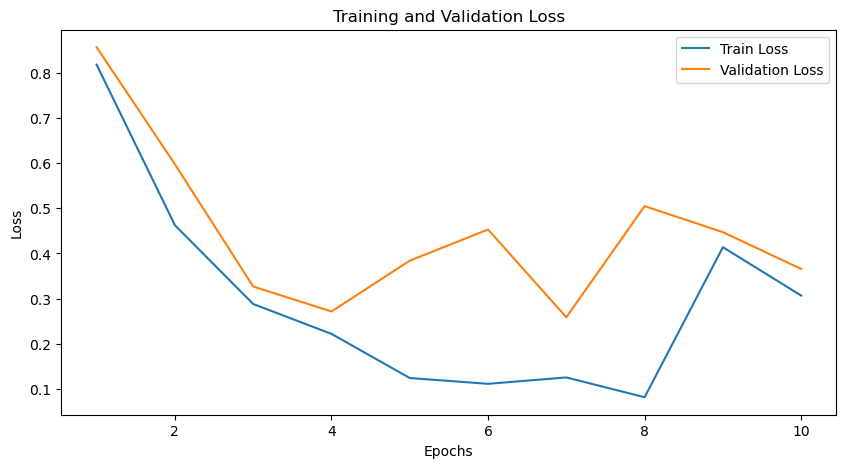

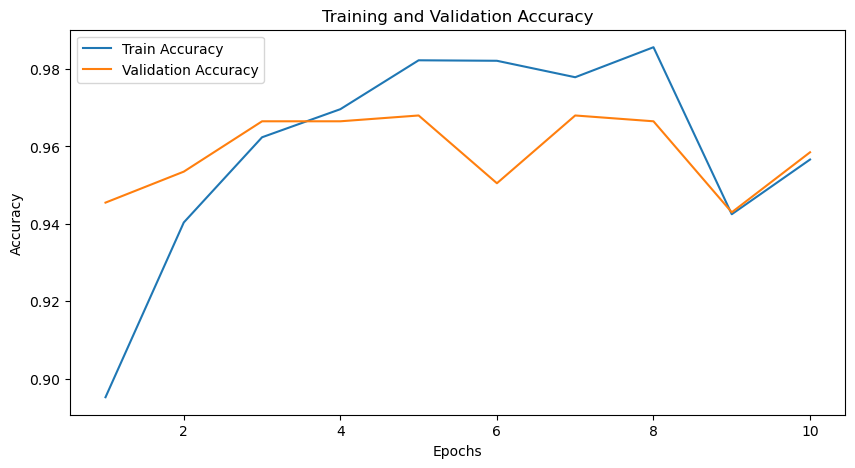

In [90]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

In [97]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()  # Ensure labels are long

            # Forward pass
            embeddings, logits = model(images)
            _, predicted = torch.max(logits, 1)

            # Collect predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Accuracy calculation
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Accuracy
    accuracy = correct / total

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm


In [93]:
# Prepare the test dataset and loader
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
filter_classes(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


Test Accuracy: 0.9575


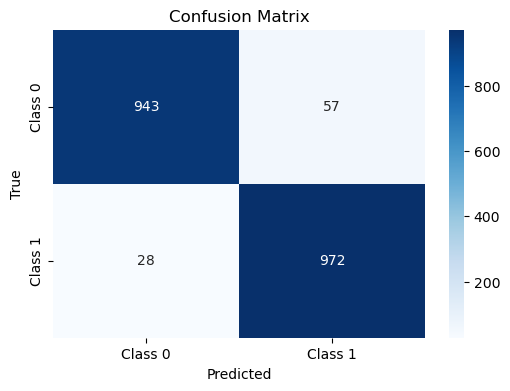

In [100]:
# Evaluate the model
accuracy, cm = evaluate_model(model, test_loader, device)

print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()